In [1]:
# set device/ GPU
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=7

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=7


In [2]:
import pandas as pd
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
import seaborn
import re
import tensorflow as tf
from utils import detect_face, predict_age_gender_race, ensure_dir
import dlib

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
2023-02-07 14:02:53.389270: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-07 14:02:54.127160: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/compat/lib.real:/opt/conda/lib/python3.8/site-packages/torch/lib:/opt/conda/lib/python3.8/site-packages/torch_tensorrt/lib:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64


In [3]:
def get_img_list(loc, occ, exp=0):
    img_list = []
    # images from laion dataset
    if loc == "laion":
        img_path = "../../occupations"
        df = pd.read_json(f"{img_path}/{occ}/laion2b_knn_face_complete.json")
        df = df.loc[df['local_image']]
        df['i'] = df['i'].apply(lambda x: f"{img_path}/{occ}/images/face/{x}.png")
        img_list = df.rename({'i': 'img_path'}, axis='columns')['img_path']
    else:
        # generated images with SD
        if loc == "generated":
            img_path = f"generated_images/gender_imgs_{model_version}/{occ}"
        # edited images (50/50) from SD
        elif loc == "edited":
            img_path = f"generated_images/gender_edited_imgs_{model_version}/{occ}"
        for i in range(0,250):
            img_list.append(f"{img_path}/image{i}.png")
    return img_list

In [4]:
with open('occupations.txt') as f:
    occupations = [line.split("   ", 1)[0] for line in f][1:]
    
model_version = "1-5"
len_ = len(occupations)
action = "gender"
classify_type = 'fairface'
dlib.DLIB_USE_CUDA = True
cnn_face_detector = dlib.cnn_face_detection_model_v1('dlib_models/mmod_human_face_detector.dat')

In [5]:
science = [1,18,21,25,45,128]
engineering = [1,4,17,25,26,27,45,47,67,89,116,134]
arts = [5,6,38,59,69,94,102,107,131,152]
caregiving = [16,22,35,36,37,43,66,82,87,91,96,97,99,108,117,132,133,138,139,141]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(pd.DataFrame(occupations))

                                   0
0                         accountant
1                 aerospace engineer
2                               aide
3         air conditioning installer
4                          architect
5                             artist
6                             author
7                              baker
8                          bartender
9                         bus driver
10                           butcher
11                  career counselor
12                         carpenter
13                  carpet installer
14                           cashier
15                               ceo
16                  childcare worker
17                    civil engineer
18                  claims appraiser
19                           cleaner
20                            clergy
21                             clerk
22                             coach
23                 community manager
24                compliance officer
25               computer programmer
2

In [6]:
# number of laion images evaluated
with open('occupations.txt') as f:
    occupati = [re.findall(r'\d+',line) for line in f][1:]
    occupati = [int(occ[1]) for occ in occupati]
print(f"all: {sum(occupati)}")
print(f"science: {sum(np.array(occupati)[science])}")
print(f"engineering: {sum(np.array(occupati)[engineering])}")
print(f"arts: {sum(np.array(occupati)[arts])}")
print(f"caregiving: {sum(np.array(occupati)[caregiving])}")

all: 1834696
science: 44366
engineering: 69852
arts: 41258
caregiving: 119118


In [7]:
ls_ = []
for i, occ in enumerate(occupations):
    if i in caregiving:
        ls_.append(occ)
ls_

['childcare worker',
 'coach',
 'dental assistant',
 'dental hygienist',
 'dentist',
 'doctor',
 'housekeeper',
 'maid',
 'massage therapist',
 'mental health counselor',
 'nurse',
 'nursing assistant',
 'occupational therapist',
 'physical therapist',
 'psychologist',
 'social assistant',
 'social worker',
 'teacher',
 'teaching assistant',
 'therapist']

**Compute for Laion independent of SD model version**

In [ ]:
loc = 'laion'
txt_file = open(f'results_{classify_type}_{loc}.txt', 'w+')
for occ in occupations: 
    man, woman = 0, 0
    SAVE_DETECTED_AT = f"detected_faces/{loc}/{occ}"
    ensure_dir(SAVE_DETECTED_AT)
    img_list = get_img_list(loc, occ)
    detect_face(img_list, SAVE_DETECTED_AT, cnn_face_detector)
    result = predict_age_gender_race(f"detected_faces/{loc}/results_fairface_{occ}.csv", SAVE_DETECTED_AT)
    man = len(result[result[action]=='Male'])
    woman = len(result[result[action]=='Female']) 

    txt_file.write(f'{occ}\n')
    txt_file.write(f'man: {man}, woman: {woman}\n')
txt_file.close()

0it [00:00, ?it/s]

---0/9405---


1004it [01:14, 15.59it/s]

---1000/9405---


2002it [02:27, 13.29it/s]

---2000/9405---


3003it [03:39, 13.16it/s]

---3000/9405---


4006it [04:51, 15.26it/s]

---4000/9405---


5003it [06:03, 13.94it/s]

---5000/9405---


6001it [07:16, 14.50it/s]

---6000/9405---


7001it [08:29, 14.90it/s]

---7000/9405---


8002it [09:41, 15.29it/s]

---8000/9405---


8243it [09:59, 19.12it/s]

**Compute for generated images for a certain SD model version**

In [ ]:
for loc in['generated', 'edited']:
txt_file = open(f'results_{classify_type}_{loc}_{model_version}.txt', 'w+')
for occ in occupations: 
    man, woman = 0, 0
    SAVE_DETECTED_AT = f"detected_faces/{model_version}/{loc}/{occ}"
    ensure_dir(SAVE_DETECTED_AT)
    img_list = get_img_list(loc, occ)
    detect_face(img_list, SAVE_DETECTED_AT, cnn_face_detector)
    result = predict_age_gender_race(f"detected_faces/{model_version}/{loc}/results_fairface_{occ}.csv", SAVE_DETECTED_AT)
    man = len(result[result[action]=='Male'])
    woman = len(result[result[action]=='Female'])

    txt_file.write(f'{occ}\n')
    txt_file.write(f'man: {man}, woman: {woman}\n')
txt_file.close()

2it [00:02,  1.13it/s]

---0/250---


250it [00:30,  8.20it/s]
0it [00:00, ?it/s]

Predicting... 0/250


250it [00:04, 56.27it/s]
2it [00:00,  8.70it/s]

---0/250---


250it [00:29,  8.53it/s]
9it [00:00, 80.97it/s]

Predicting... 0/250


250it [00:03, 68.38it/s]
2it [00:00,  9.26it/s]

---0/250---


250it [00:28,  8.69it/s]
6it [00:00, 49.40it/s]

Predicting... 0/250


250it [00:04, 53.99it/s]
2it [00:00,  9.22it/s]

---0/250---


250it [00:28,  8.74it/s]
2it [00:00, 16.03it/s]

Predicting... 0/250


250it [00:05, 47.99it/s]
2it [00:00,  9.26it/s]

---0/250---


250it [00:28,  8.89it/s]
14it [00:00, 68.41it/s]

Predicting... 0/250


250it [00:04, 57.84it/s]
1it [00:00,  7.79it/s]

---0/250---


250it [00:28,  8.78it/s]
5it [00:00, 42.66it/s]

Predicting... 0/250


250it [00:05, 45.96it/s]
3it [00:00,  9.37it/s]

---0/250---


250it [00:28,  8.74it/s]
6it [00:00, 59.27it/s]

Predicting... 0/250


250it [00:04, 59.46it/s]
2it [00:00,  9.79it/s]

---0/250---


250it [00:28,  8.83it/s]
8it [00:00, 77.78it/s]

Predicting... 0/250


250it [00:04, 56.46it/s]
1it [00:00,  8.92it/s]

---0/250---


250it [00:28,  8.70it/s]
4it [00:00, 31.14it/s]

Predicting... 0/250


250it [00:04, 50.62it/s]
2it [00:00,  9.88it/s]

---0/250---


250it [00:28,  8.66it/s]
4it [00:00, 34.11it/s]

Predicting... 0/250


250it [00:04, 56.00it/s]
2it [00:00, 10.01it/s]

---0/250---


177it [00:19, 10.11it/s]

no face found 175


250it [00:27,  8.97it/s]
5it [00:00, 45.42it/s]

Predicting... 0/249


249it [00:04, 60.87it/s]
2it [00:00,  9.13it/s]

---0/250---


250it [00:28,  8.69it/s]
3it [00:00, 24.67it/s]

Predicting... 0/250


250it [00:04, 51.82it/s]
2it [00:00,  8.20it/s]

---0/250---


250it [00:28,  8.74it/s]
9it [00:00, 89.11it/s]

Predicting... 0/250


250it [00:04, 61.46it/s]
2it [00:00,  9.03it/s]

---0/250---


250it [00:28,  8.80it/s]
10it [00:00, 95.48it/s]

Predicting... 0/250


250it [00:04, 61.07it/s]
3it [00:00,  8.85it/s]

---0/250---


250it [00:28,  8.78it/s]
6it [00:00, 51.34it/s]

Predicting... 0/250


250it [00:03, 67.29it/s]
2it [00:00,  9.55it/s]

---0/250---


250it [00:27,  9.08it/s]
6it [00:00, 57.68it/s]

Predicting... 0/250


250it [00:04, 60.71it/s]
1it [00:00,  7.71it/s]

---0/250---


250it [00:29,  8.56it/s]
9it [00:00, 86.54it/s]

Predicting... 0/250


250it [00:03, 66.45it/s]
2it [00:00,  9.38it/s]

---0/250---


250it [00:28,  8.79it/s]
9it [00:00, 83.72it/s]

Predicting... 0/250


250it [00:04, 53.55it/s]
3it [00:00,  9.76it/s]

---0/250---


250it [00:27,  8.98it/s]
6it [00:00, 55.64it/s]

Predicting... 0/250


250it [00:03, 62.96it/s]
1it [00:00,  4.93it/s]

---0/250---


250it [00:27,  9.04it/s]
5it [00:00, 45.35it/s]

Predicting... 0/250


250it [00:04, 60.17it/s]
1it [00:00,  9.22it/s]

---0/250---


250it [00:28,  8.84it/s]
9it [00:00, 86.90it/s]

Predicting... 0/250


250it [00:04, 60.13it/s]
2it [00:00, 10.00it/s]

---0/250---


250it [00:28,  8.64it/s]
10it [00:00, 90.95it/s]

Predicting... 0/250


250it [00:03, 65.98it/s]
2it [00:00,  9.83it/s]

---0/250---


250it [00:28,  8.81it/s]
8it [00:00, 75.87it/s]

Predicting... 0/250


250it [00:28,  8.85it/s]
6it [00:00, 48.81it/s]

Predicting... 0/250


250it [00:04, 50.96it/s]
2it [00:00,  8.95it/s]

---0/250---


250it [00:28,  8.66it/s]
10it [00:00, 97.37it/s]

Predicting... 0/250


250it [00:03, 62.73it/s]
1it [00:00,  5.23it/s]

---0/250---


250it [00:28,  8.77it/s]
5it [00:00, 47.07it/s]

Predicting... 0/250


250it [00:04, 57.01it/s]
1it [00:00,  9.39it/s]

---0/250---


217it [00:24,  8.85it/s]

**Generate plot of Results**

In [28]:
def load_from_txt(fname):
    df = pd.read_csv(fname, sep= ' ', skiprows = range(0,len_*2,2), header=None)
    df = df.drop(columns=[0,2,4,5])
    df.iloc[:,0] = df.iloc[:,0].apply(lambda a: a.replace(',', ''))
    df.iloc[:,1] = df.iloc[:,1].apply(lambda a: a.replace(',', ''))
    df = df.astype(int)
    df = df.div(df.sum(axis=1), axis=0)
    return df.iloc[:,1]

**Compute best edit technique**

In [68]:
#for fname in ['results_fairface_generated_1-5.txt', 'results_fairface_edited_1-5.txt', 'results_fairface_laion.txt', ]:
df1 = load_from_txt('results_fairface_generated_1-5.txt')
df2 = load_from_txt(f'results_fairface_edited_1-5.txt')
df3 = load_from_txt('results_fairface_laion.txt')

In [69]:
# pick top 6 occupations to visualize
occ_dict = {k: v for v, k in enumerate(occupations)}
occs_ = ['firefighter', 'social worker', 'coach', 'designer', 'teacher', 'aide']
occ_ids = [occ_dict[oc] for oc in occs_]
#social worker

# select values for top occs
generated = df1.loc[occ_ids].to_numpy()
edited = df2.loc[occ_ids].to_numpy()
laion_base = df3.loc[occ_ids].to_numpy()

# compute occupation proportion mean for each method
means = [df1.mean(), df2.mean(), df3.mean()]
errs = [df1.std(), df2.std(), df3.std()]

# select fe/male bias lists for amp/ref/mit evaluation
ids = df3<0.5
ids_ = df3>=0.5

ids1 = df1[ids].index
ids2 = df2[ids].index
ids3 = df3[ids].index
ids1_ = df1[ids_].index
ids2_ = df2[ids_].index
ids3_ = df3[ids_].index
# len of more female-biased, i.e. in total more occupations are male-biased
len(ids1_)

61

In [70]:
# LAION statistics.
print(df1[science].mean(), df1[science].std())
print(df1[engineering].mean(), df1[engineering].std())
print(df1[arts].mean(), df1[arts].std())
print(df1[caregiving].mean(), df1[caregiving].std())

0.3419999999999999 0.17094092546842024
0.18933333333333335 0.14790004814882327
0.5464 0.24058595137704947
0.7556926829268291 0.2610700588991194


In [71]:
# amount of occupations where there is no significant bias present in the first place
m = 0
for i in df3:
    if 0.47 < i < 0.53:
        m += 1
m/len(df3)

0.0457516339869281

In [72]:
# LAION vs SD: amount of occupations where bias is amplified, reflected, or mitigated by SD compared to LAION
amp, ref, mit = 0, 0, 0
for i in range(len(df3)):
    if df3[i]-0.04 < df1[i] < df3[i] +0.04:
        ref += 1
    elif abs(df3[i]-0.5) < abs(df1[i]-0.5):
        amp += 1
    elif abs(df3[i]-0.5) >= abs(df1[i]-0.5):
        mit += 1
print(amp/len(df3), ref/len(df3), mit/len(df3))

0.5686274509803921 0.21568627450980393 0.21568627450980393


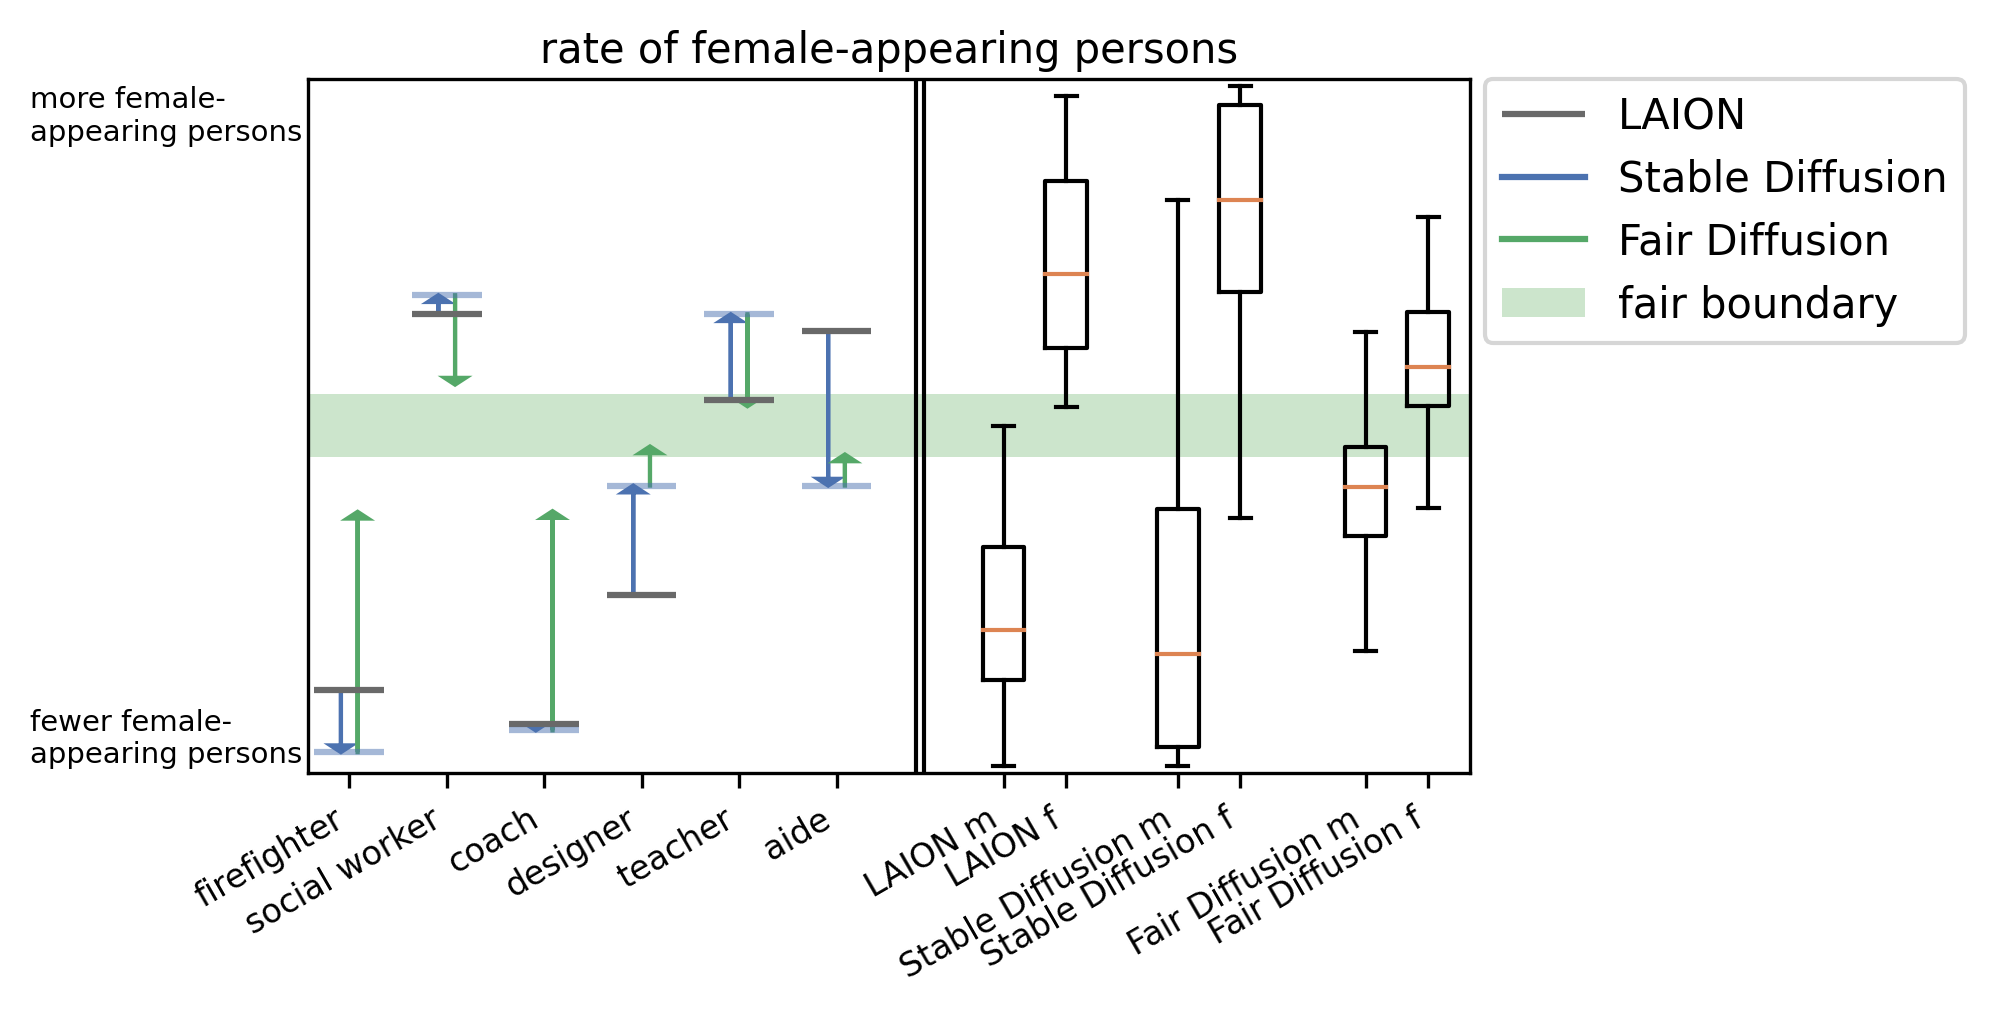

In [73]:
%matplotlib inline

fig = plt.figure(dpi=300,figsize=(5, 3.4))
seaborn.set_palette("deep")
colors = seaborn.color_palette("deep")
ax = plt.gca()

occs = occs_ + ['LAION m', 'LAION f', 'Stable Diffusion m', 'Stable Diffusion f', 'Fair Diffusion m', 'Fair Diffusion f']

first = np.arange(0, 0.7*6, 0.7)
x_pos = np.append(first, np.array([4.7,5.15,5.95,6.4,7.3,7.75]))

# separate two image parts
ax.vlines(x = x_pos[5]+0.6-0.03, ymin = -0.01, ymax=1.01, colors='black',linewidth=1)
ax.vlines(x = x_pos[5]+0.6+0.03, ymin = -0.01, ymax=1.01, colors='black',linewidth=1)

# plot fair boundary with gradient background
ax.barh(0.5, width=10.3, height=0.093, left=-0.3, color='green', alpha=0.2, label='fair boundary')

# plot laion bars
ax.hlines(y = laion_base, xmin = x_pos[:6]-0.25, xmax = x_pos[:6]+0.25, colors='dimgray', label='LAION')
# plot SD bars
ax.hlines(y = generated, xmin = x_pos[:6]-0.25, xmax = x_pos[:6]+0.25, colors=colors[0], label='SD_', alpha=0.5)

# plot arrows for sd and sega
for i in range(len(laion_base)):
    if i==0:
        lbl, lbl_ = 'Fair Diffusion', 'Stable Diffusion'
    else:
        lbl, lbl_ = '_nolegend_', '_nolegend_'
    ax.arrow(y=laion_base[i], x=x_pos[i]-0.06, dy=generated[i] - laion_base[i], dx=0, head_width=0.15, head_length=0.01, length_includes_head=True, fc=colors[0], ec=colors[0], label=lbl_)
    ax.arrow(y=generated[i], x=x_pos[i]+0.06, dy=edited[i] - generated[i], dx=0, head_width=0.15, head_length=0.01, length_includes_head=True, fc=colors[2], ec=colors[2], label=lbl,)

    
# plot box plots for average scores
ax.boxplot(df3[ids3], positions=[x_pos[6]], vert=True, widths=0.3, sym='')
ax.boxplot(df3[ids3_], positions=[x_pos[7]], vert=True, widths=0.3, sym='')
ax.boxplot(df1[ids1], positions=[x_pos[8]], vert=True, widths=0.3, sym='')
ax.boxplot(df1[ids1_], positions=[x_pos[9]], vert=True, widths=0.3, sym='')
ax.boxplot(df2[ids2], positions=[x_pos[10]], vert=True, widths=0.3, sym='')
ax.boxplot(df2[ids2_], positions=[x_pos[11]], vert=True, widths=0.3, sym='')


# Add labels to the axes and the legend
ax.set_xticks(x_pos, labels=occs)
ax.set_ylim(ymin=-0.01, ymax=1.01)
ax.set_xlim(xmin=x_pos[0]-0.3,xmax=x_pos[-1]+0.3)
ax.set_yticks([])

# refine handles
handles, labels = ax.get_legend_handles_labels()
sd_handle = mlines.Line2D([], [], color=colors[0], label='Stable Diffusion')
sega_handle = mlines.Line2D([], [], color=colors[2], label='Fair Diffusion')

ax.set_xticklabels(fontsize=8, color='black', labels=occs)
ax.set_xlabel('rate of female-appearing persons')
ax.legend(bbox_to_anchor=(0.995, 0.59),handles=[handles[0],sd_handle,sega_handle,handles[4]])
plt.text(-0.06, 0.82, 'more female-\nappearing persons', fontsize=7, transform=plt.gcf().transFigure)
plt.text(-0.06, 0.21, 'fewer female-\nappearing persons', fontsize=7, transform=plt.gcf().transFigure)
ax.xaxis.set_label_position('top') 
fig.autofmt_xdate()

plt.savefig('figure.png', format='png', bbox_inches='tight',dpi=500)
plt.savefig('figure.svg', bbox_inches='tight',dpi=500)
plt.show()